In [2]:
import pandas as pd
import plotly.graph_objects as go
import torch

from darts.dataprocessing.transformers import Scaler

In [5]:
path = "../../Dataset"

In [6]:
df = pd.read_excel(f'{path}/kawaldata_clean.xlsx', parse_dates=True)
df.head()

## **Vaccination Indonesia Statistics**

In [403]:
df_vaccine = pd.concat([df['tanggal'], df['Dosis kedua']], axis=1)
df_vaccine = df_vaccine.dropna()

df_vaccine['Dosis kedua'] = df_vaccine['Dosis kedua'].astype(int)
print(f'Total Vaccine Days {len(df_vaccine)}')

Total Vaccine Days 208


In [404]:
line_stat = []
line_stat.append(go.Scatter(x=df_vaccine.tanggal, y=df_vaccine['Dosis kedua'], name="Dosis Kedua", mode='lines'))

fig = go.Figure(data=line_stat)
fig.update_layout(title_text="Vaccination Indonesia")
fig.show()

## **Time Series Feature Engineering**

- Filling NaN Value With 0
- Seperating Train Variable With Date

In [405]:
df_timeseries = df_vaccine

In [406]:
df_timeseries.tail()

,tanggal,Dosis kedua
533,2021-08-18,29527386
534,2021-08-19,30230233
535,2021-08-20,30585478
536,2021-08-21,31566685
537,2021-08-22,31601400


In [407]:
variable = df_timeseries.loc[:, df_timeseries.columns != 'tanggal']
variable = list(variable)
variable


['Dosis kedua']

## **Time Series Modelling**

In [408]:
from darts import TimeSeries

series = TimeSeries.from_dataframe(df_timeseries, 'tanggal', variable)
train = series


In [409]:
from darts.models import NBEATSModel
model = NBEATSModel(
    input_chunk_length = 10,
    output_chunk_length = 7
)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

model.fit(train, verbose=True)

[2021-08-23 21:26:02,150] INFO | darts.models.torch_forecasting_model | Train dataset contains 192 samples.
[2021-08-23 21:26:02,150] INFO | darts.models.torch_forecasting_model | Train dataset contains 192 samples.


cuda:0


  0%|          | 0/100 [00:00<?, ?it/s]

In [410]:
pred_series = model.historical_forecasts(
    train,
    start=pd.Timestamp("2021-03-20"),
    retrain=False,
    verbose=True
)

  0%|          | 0/156 [00:00<?, ?it/s]

R2 Score: 0.9995248575888621


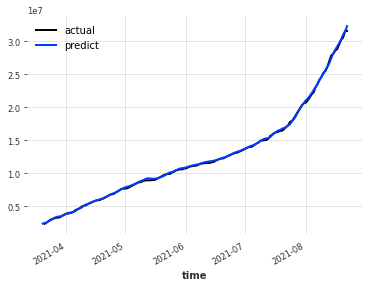

In [411]:
ts_transformed['Dosis kedua'].univariate_component(0).plot(label='actual')
pred_series['0'].plot(label='predict')

print('R2 Score:', r2_score(ts_transformed.univariate_component(0), pred_series['0']))

## **Future Prediction**

In [412]:
prediction = model.predict(100)
prediction = prediction.pd_dataframe()

In [413]:
series = series.pd_dataframe()

In [424]:
min_case = date(2021, 8, 23) - date(2021, 11, 6)
min_case = abs(min_case.days)
dates = list(pd.date_range(start="2021-08-23", periods=min_case))

In [415]:
prediction = prediction.reset_index()
series = series.reset_index()

for i, col in enumerate(variable):
    prediction = prediction.rename(columns={'{}'.format(i) : col})
    series = series.rename(columns={'{}'.format(i): col})

In [427]:
line_stat = []

for x in range(0,1):
    line_stat.append(go.Scatter(x=df_timeseries.tanggal, y=series[variable[x]], name=variable[x], mode='lines'))
    line_stat.append(go.Scatter(x=dates, y=prediction[variable[x]], name=f'Forecast {variable[x]}', mode='lines'))

fig = go.Figure(data=line_stat)
fig.update_layout(title_text=f"Indonesia Vaccination Within {min_case} Days Periods")
fig.show()

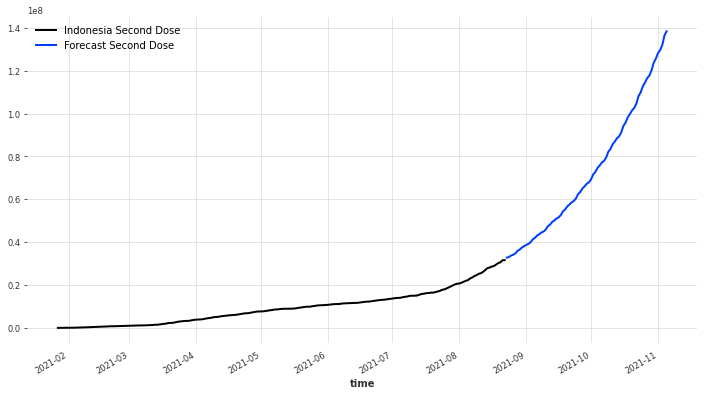

In [430]:
import matplotlib.pyplot as plt

prediction = model.predict(min_case)
plt.figure(figsize=(12, 6))

train['Dosis kedua'].plot(label='Indonesia Second Dose')
prediction['0'].plot(label='Forecast Second Dose')